# 1. Data

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import graph

Let's start by loading the datasets and by saving them into three separate dataframes

In [12]:
# Answers to questions
df_a2q = pd.read_table("data/sx-stackoverflow-a2q.txt", 
                       delimiter=" ", 
                       names=["src", "tgt", "timestamp"],
                       nrows=10000)

# Comments to answers
df_c2a = pd.read_table("data/sx-stackoverflow-c2a.txt", 
                       delimiter=" ", 
                       names=["src", "tgt", "timestamp"],
                       nrows=10000)

# Comments to questions
df_c2q = pd.read_table("data/sx-stackoverflow-c2q.txt", 
                       delimiter=" ", 
                       names=["src", "tgt", "timestamp"],
                       nrows=10000)

Let's also convert the UNIX times in the `timestamp` column into `datetime` objects

In [13]:
df_a2q["timestamp"] = pd.to_datetime(df_a2q["timestamp"], unit='s')
df_c2a["timestamp"] = pd.to_datetime(df_c2a["timestamp"], unit='s')
df_c2q["timestamp"] = pd.to_datetime(df_c2q["timestamp"], unit='s')

Now we can save all three as separate graphs (ignoring rows with users commenting their own comments/answers)

In [62]:
G_a2q = graph.graph_from_df(df_a2q)   
G_c2a = graph.graph_from_df(df_c2a)
G_c2q = graph.graph_from_df(df_c2q)

in order to merge them into a single graph `G`, which will contain all nodes and edges in the three graphs, assigning to each edge a `timestamp` attribute (with the older date among the three graphs) and a `weight` attribute (i.e. the number of graphs that edge was in)

In [63]:
G = graph.merge_graphs(G_c2a, G_c2q)
G = graph.merge_graphs(G, G_a2q)

To check if our own implementation works, we can test it against `networkx`'s, and see if the two merged graphs have the same nodes and each of those has the same neighbors:

In [16]:
Gx_a2q = graph.graph_from_df(df_a2q, "networkx")   
Gx_c2a = graph.graph_from_df(df_c2a, "networkx")
Gx_c2q = graph.graph_from_df(df_c2q, "networkx")

Gx = nx.compose(Gx_c2a, Gx_c2q)
Gx = nx.compose(Gx, Gx_a2q)

graph.test_graph(G, Gx)

OK! Same nodes and neighbors


By merging the three graphs, we obtain

In [17]:
G.summary()

Directed graph with 6763 nodes and 22449 edges


where each edge has by default a direction (unlike `Gx` which is undirected), which will be that of the older interaction between the two users (i.e. the first occurrence in the dataframe, whose entries are in chronological order from oldest to newest).

For instance, let's take a look at 6 of the neighbors of the node `404`:

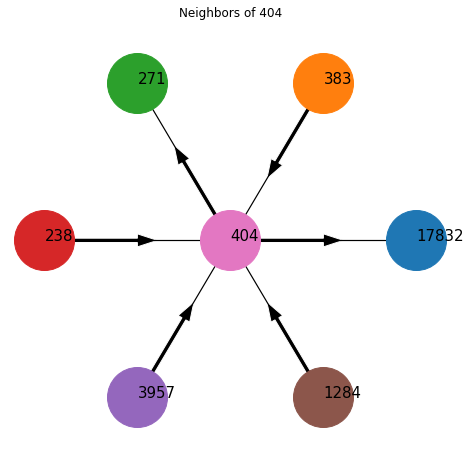

In [10]:
plt = graph.plot_neighbors(G, "404", max_neighbors=6)
plt.show()

# 2/3. Functionalities & Visualization

In [18]:
from func import func_selector
import visual

### Functionality 1 - Overall features of the graph

Let's take a look at the overall features of one of the graphs we built and the distribution of the degrees of each of its nodes.

,Graph features
Directed,True
Users,1501
Answers/comments,9248
Avg links per user,6.16
Dense (|E| ~ |V|^2),True


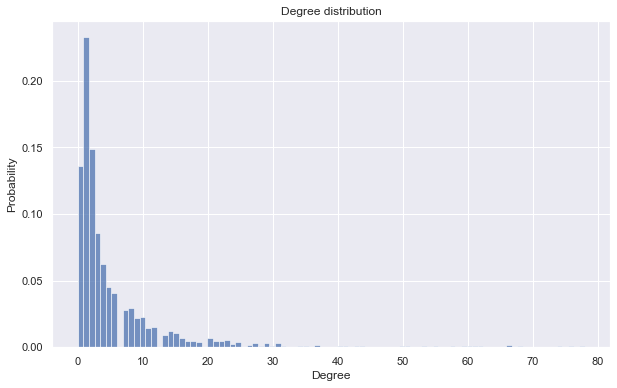

In [31]:
table, density = func_selector(G_a2q, 1)

plt.figure(figsize = (10,6))
visual.overall_features(G_a2q, table, density)
plt.show()

The vast majority of nodes have a degree close to zero, but there also many outliers which have a much higher degree than the rest, as we can appreciate in the box plot below.

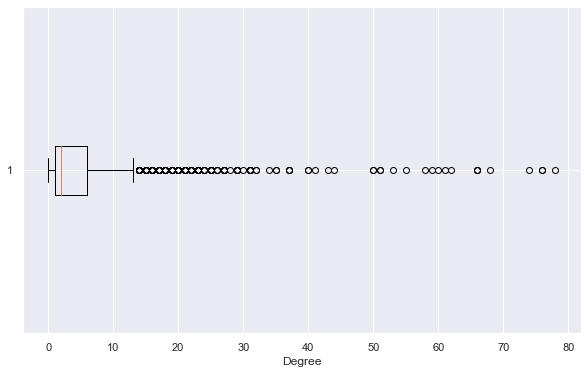

In [32]:
plt.figure(figsize = (10,6))
plt.boxplot(density, vert=False)
plt.xlabel("Degree")
plt.show()

### Functionality 2 - Find the Best users!

In [218]:
from importlib import reload
import func
reload(func)
from func import func_selector

reload(graph)
import graph

#### Degree Centrality

In [69]:
func_selector(G, 2)

Node 238
Time start [yyyy-mm-dd] 2008-08-01
Time end [yyyy-mm-dd] 2008-08-10
Metric [btw | pagerank | cc | dc] dc


0.012987012987012988

#### Pagerank

In [219]:
func_selector(G, 2)

Node 238
Time start [yyyy-mm-dd] 2008-08-01
Time end [yyyy-mm-dd] 2008-08-10
Metric [btw | pagerank | cc | dc] pagerank


0.003447465483984921

# 4. Algorithmic question

A number n of kids are in a camp. Between some k pairs of them (a kid can be part of more than one pairs) there are often fights. At night there are two dormitories where the kids can sleep. We want, if possible, to assign each kid in one of the two dormitories in such a way that each pair of kids that fights often is assigned to a different dormitory. (There are no space problems and the two dormitories can have different number of kids.)

In [16]:
n = [1,3,4,56,7,32,2]
n.sort()
n

[1, 2, 3, 4, 7, 32, 56]

In [17]:
def tuple_order(k):
    out = []
    for pair in k:
        if(pair[0] > pair[1]):
            pair = list(pair)
            temp = pair[0]
            pair[0] = pair[1]
            pair[1] = temp
            pair = tuple(pair)
        out.append(pair)
    return out

In [18]:
# n -> list of kids
# k -> list of pairs of kids fighting
def dorm_algo(n, k):
    # kids in 1st and 2nd dorm
    dorm0 = []
    dorm1 = []
    # Creating a list for kids who don't get in argues
    safe = []
    
    # First of all I order the list of kids...
    n.sort()
    # ...and the elements of the pairs using the aux function
    k = tuple_order(k)
    # Then I start checking
    for pair in k:
        if(pair[0] not in safe): # if kid0 not in safe list...
            safe.append(pair[0]) # ...I add him...
            dorm0.append(pair[0]) # ...and put him in dorm0
        
        if(pair[1] not in safe): # if kid1 not in safe list...
            safe.append(pair[1]) # ...I add him...
            dorm1.append(pair[1]) # ...and put him in dorm1
            
    # Now I check if kids from the same pairs are in the same dorm
    # If so, I block the algorithm
    for pair in k:
        if(((pair[0] in dorm0) and (pair[1] in dorm0)) or (pair[0] in dorm1) and (pair[1] in dorm1)):
            print("Nothing can be done!")
            return 
    
    # Now is time to add the other kids in the dorms
    for kid in n:
        if((kid not in dorm0) and (kid not in dorm1)):
            dorm0.append(kid)
            
    # Print the final dorms with the kids
    print("Fighting solved! Here the dorms:")
    print("First dormitory:", dorm0)
    print("Second dormitory:",dorm1)

Let's use as list of kids this:

In [19]:
n = [1,2,3,4,5,6]

In [20]:
k = [(3,2), (4,2)]
dorm_algo(n, k)

Fighting solved! Here the dorms:
First dormitory: [2, 1, 5, 6]
Second dormitory: [3, 4]


In [21]:
k = [(1,3),(4,1),(3,4)] 
dorm_algo(n, k)

Nothing can be done!


In [22]:
k = [(5,4), (6,5), (2,6)]
dorm_algo(n, k)

Nothing can be done!


In [23]:
k = [(5,4), (6,5)]
dorm_algo(n, k)

Nothing can be done!


In [24]:
k = [(1,3),(4,1),(3,2),(2,5),(1,2)]
dorm_algo(n,k)

Nothing can be done!


In [25]:
k = [(1,3),(4,1),(3,2),(2,5),(2,6)]
dorm_algo(n,k)

Fighting solved! Here the dorms:
First dormitory: [1, 2]
Second dormitory: [3, 4, 5, 6]
